In [1]:
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import cv2
import numpy as np
import os
import joblib

In [2]:
# 1. 数据准备
train_path = "Dataset"  # 训练数据集路径
test_path = "Dataset"   # 测试数据集路径
train_images = []       # 存储训练图像的灰度图像列表
train_labels = []       # 存储训练图像的标签列表
test_images = []        # 存储测试图像的灰度图像列表
test_labels = []        # 存储测试图像的标签列表

# 遍历训练数据集的每个类别目录
for category in os.listdir(train_path):
    # 对每个类别的前150张图像进行处理
    for filename in os.listdir(os.path.join(train_path, category))[:150]:
        # 读取图像并转换为灰度图像
        img = cv2.imread(os.path.join(train_path, category, filename))
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # 将灰度图像和对应的类别标签添加到训练集列表中
        train_images.append(img_gray)
        train_labels.append(category)

    # 对每个类别的后面的图像（超过150张）进行处理，作为测试集
    for filename in os.listdir(os.path.join(train_path, category))[150:]:
        # 读取图像并转换为灰度图像
        img = cv2.imread(os.path.join(train_path, category, filename))
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # 将灰度图像和对应的类别标签添加到测试集列表中
        test_images.append(img_gray)
        test_labels.append(category)

In [31]:
# 2. 特征提取和表示（使用空间金字塔）
def extract_features_with_pyramid(images):
    sift = cv2.SIFT_create()  # 创建SIFT特征提取器
    descriptors = []          # 存储图像的特征描述符列表
    for img in images:
        pyramid_descriptors = []  # 存储图像的金字塔特征描述符列表
        for level in range(3):   # 三级空间金字塔
            scale = 2 ** level    # 计算金字塔缩放比例
            # 将图像按照缩放比例进行缩放
            resized_img = cv2.resize(img, (img.shape[1] // scale, img.shape[0] // scale))
            # 使用SIFT提取缩放后图像的关键点和特征描述符
            kp, des = sift.detectAndCompute(resized_img, None)
            # 如果存在特征描述符，则将其添加到金字塔特征描述符列表中
            if des is not None:
                pyramid_descriptors.extend(des)
        # 将金字塔特征描述符列表添加到总的特征描述符列表中
        descriptors.append(pyramid_descriptors)
    return descriptors

# 对训练集和测试集图像提取空间金字塔特征描述符
train_descriptors = extract_features_with_pyramid(train_images)
test_descriptors = extract_features_with_pyramid(test_images)


In [36]:
# 加载SVM分类器
svm_model = joblib.load('pkl2/svm_model.pkl')

# 加载K均值聚类器
kmeans_model = joblib.load('pkl2/kmeans_model.pkl')

d:\software\anaconda\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator SVC from version 1.0.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
d:\software\anaconda\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator KMeans from version 1.0.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [37]:
visual_words = kmeans_model.cluster_centers_

In [38]:
test_features = []  # 存储测试集图像的特征表示列表
# 遍历测试集图像的特征描述符列表
for descriptors in test_descriptors:
    histogram = np.zeros(len(kmeans_model.cluster_centers_), dtype=np.float32)  # 初始化特征直方图向量

    if descriptors is not None:
        # 使用K均值模型对测试图像的特征描述符进行聚类，获取对应的类别标签
        labels = kmeans_model.predict(descriptors)
        # 统计每个类别标签的出现次数，构建特征直方图
        for label in labels:
            histogram[label] += 1

        # 将特征直方图添加到特征表示列表中
        test_features.append(histogram)


In [ ]:
import matplotlib.pyplot as plt

def plot_histogram(histogram):
    plt.bar(range(len(histogram)), histogram)
    plt.xlabel('Cluster Center Index')
    plt.ylabel('Frequency')
    plt.title('Feature Vector Histogram')
    plt.show()

# 示例：绘制特征向量的直方图
plot_histogram(test_features[0])


In [39]:
# 6. 评估分类器
predictions = svm_model.predict(test_features)
accuracy = accuracy_score(test_labels, predictions)
print("Accuracy:", accuracy)


Accuracy: 0.548993288590604


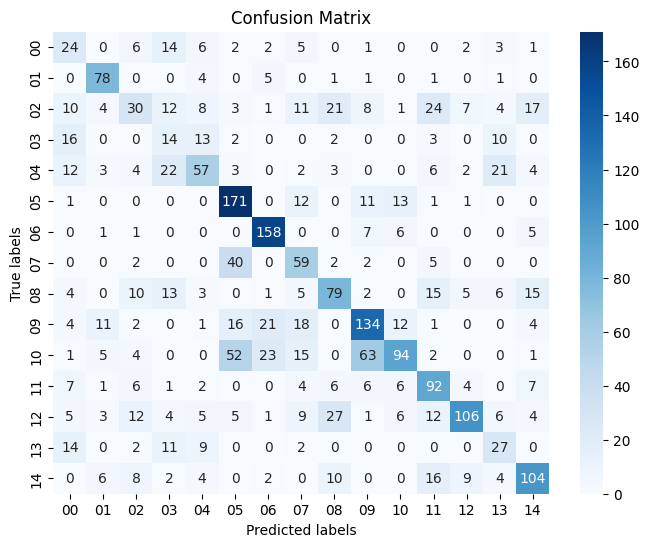

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 7. 评估分类器
predictions = svm_model.predict(test_features)

# 计算混淆矩阵
conf_matrix = confusion_matrix(test_labels, predictions)

# 输出混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
